## For Testing

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.models import load_model
import deepchem as dc
import mol2vec.features as mf
import numpy as np
import os



In [95]:
## MODEL ARCHITECTURE 
'''
def build_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dense(1)  
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_model(X_train.shape[1])
model.summary()
'''

"\ndef build_model(input_shape):\n    model = Sequential([\n        Dense(128, activation='relu', input_shape=(input_shape,)),\n        Dropout(0.3),\n        Dense(64, activation='relu'),\n        Dense(1)  \n    ])\n    model.compile(optimizer='adam', loss='mse', metrics=['mae'])\n    return model\n\nmodel = build_model(X_train.shape[1])\nmodel.summary()\n"

In [96]:
# load the model
model = load_model("models/trained_model.h5", compile=False)
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt, loss='mse', metrics=['mae'])  # or [tf.keras.metrics.MeanAbsoluteError()]
scaler = joblib.load("models/scalar.pkl")


c:\Users\hasna\myenv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [97]:
# Download the mol2Vector model from the following link
# https://deepchemdata.s3-us-west-1.amazonaws.com/trained_models/mol2vec_model_300dim.tar.gz

# Download the model, unzip it  and paste it in the models folder


current_dir = os.getcwd()

# Download the file from the above link
model_path = os.path.join(current_dir, "models/mol2vec_model_300dim.pkl")

def sentences2vec_g4(sentences, model, unseen=None):
    kv = model.wv
    keys = kv.key_to_index
    out = []
    for sentence in sentences:
        toks = []
        for w in sentence:
            if w in keys:
                toks.append(w)
            elif unseen is not None and unseen in keys:
                toks.append(unseen)
        if toks:
            vec = np.sum([kv.get_vector(w) for w in toks], axis=0)
        else:
            vec = np.zeros(kv.vector_size, dtype=np.float32)
        out.append(vec)
    return np.array(out)

mf.sentences2vec = sentences2vec_g4  
featurizer = dc.feat.Mol2VecFingerprint(
    pretrain_model_path=model_path
)

In [98]:
def plot_correlation(y_true, y_pred, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.xlabel("Actual Solubility")
    plt.ylabel("Predicted Solubility")
    plt.title(title)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')  # Diagonal line
    plt.show()

## RMSE and Pearson Correlation on Cui et al Test Split.

In [99]:
# 1. Load the Mol2Vector dataset
data = pd.read_csv("Dataset/Mol2VecFingerprint.csv")  

# 2. Extract features (X) and target (y)
X = data.filter(regex="MDesc_").values  # Select all 300 MDesc_* columns
y = data["logS"].values  # Target column

# 3. Split into train/test/validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 4. Normalize features (only non-binary data)
#scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit scaler to training data
X_val = scaler.transform(X_val)          # Use same scaler for validation/test
X_test = scaler.transform(X_test)

FileNotFoundError: [Errno 2] No such file or directory: 'Dataset/Mol2VecFingerprint.csv'

In [ ]:
# Predictions
y_train_pred = model.predict(X_train).flatten() 
y_test_pred = model.predict(X_test).flatten()   
print(y_train_pred)

199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[-2.9732773 -2.300677  -2.8282318 ... -6.421718  -1.7974331 -3.822863 ]


In [ ]:
training_y= pd.DataFrame({
       'Actual Solubility of Training dataset' : y_train, 
       'Predicted Solubility of Trainign dataset' : y_train_pred
})

test_y = pd.DataFrame({
    'Actual Solubility of Test Data set' : y_test , 
    'Predicted Solubility of Test Dataset' : y_test_pred    
})

test_y.head()
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
test_rmse = np.sqrt(test_loss)  

print(f"Test set (Cui et al) RMSE: {test_rmse:.3f}")


Test set (Cui et al) RMSE: 0.907


Test Set (Cui et al) Pearson Correlation: 0.917


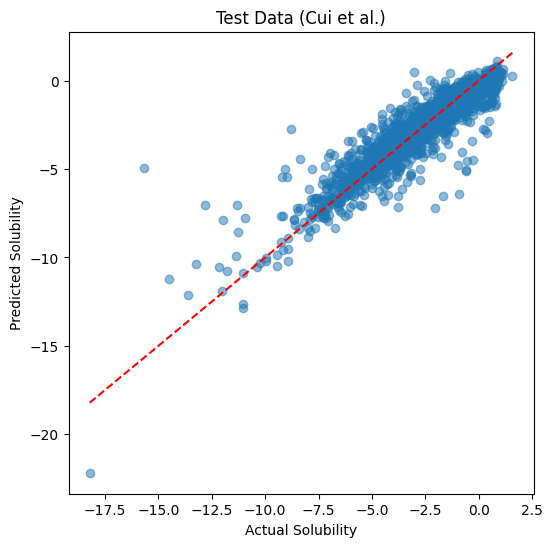

In [ ]:
# Pearson Correlation on the test data
corr_matrix_test = np.corrcoef(y_test, y_test_pred)
corr_test = corr_matrix_test[0, 1]
print(f"Test Set (Cui et al) Pearson Correlation: {corr_test:.3f}")
plot_correlation(y_test, y_test_pred, "Test Data (Cui et al.)")


## RMSE and Pearson Correlation on Four External Datasets

[22:10:21] DEPRECATION WARNING: please use MorganGenerator
[22:10:21] DEPRECATION WARNING: please use MorganGenerator
[22:10:21] DEPRECATION WARNING: please use MorganGenerator
[22:10:21] DEPRECATION WARNING: please use MorganGenerator
[22:10:21] DEPRECATION WARNING: please use MorganGenerator
[22:10:21] DEPRECATION WARNING: please use MorganGenerator
[22:10:21] DEPRECATION WARNING: please use MorganGenerator
[22:10:21] DEPRECATION WARNING: please use MorganGenerator
[22:10:21] DEPRECATION WARNING: please use MorganGenerator
[22:10:21] DEPRECATION WARNING: please use MorganGenerator
[22:10:21] DEPRECATION WARNING: please use MorganGenerator
[22:10:21] DEPRECATION WARNING: please use MorganGenerator
[22:10:21] DEPRECATION WARNING: please use MorganGenerator
[22:10:21] DEPRECATION WARNING: please use MorganGenerator
[22:10:21] DEPRECATION WARNING: please use MorganGenerator
[22:10:21] DEPRECATION WARNING: please use MorganGenerator
[22:10:21] DEPRECATION WARNING: please use MorganGenerat

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
RMSE: 0.717
Pearson Correlation: 0.708


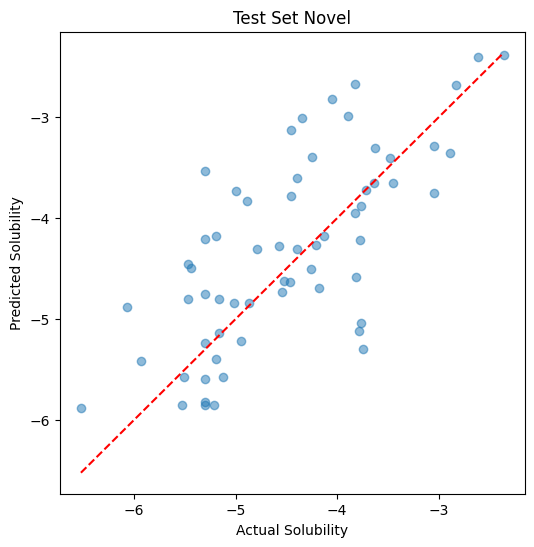

In [100]:
# tesSetNovel RMSE and Pearson correlation

y_test_csv = pd.read_csv("Test_Datasets/testSetNovel.csv")
y_test = np.array(y_test_csv["logS"])

smiles_list = np.array(y_test_csv["SMILES"])
len = smiles_list.shape[0]
featurizer = dc.feat.Mol2VecFingerprint(pretrain_model_path=model_path)
features = [featurizer.featurize(smile) for smile in smiles_list]
features = np.array(features)
features= features.squeeze()  
features=features.reshape(len, 300)
features = scaler.transform(features)
predicted_y_test = model.predict(features).flatten() 
test_loss, test_mae = model.evaluate(features, y_test, verbose=0)
test_rmse = np.sqrt(test_loss)  
print(f"RMSE: {test_rmse:.3f}") 
corr_matrix_test = np.corrcoef(y_test, predicted_y_test)
corr_test = corr_matrix_test[0, 1]
print(f"Pearson Correlation: {corr_test:.3f}")
plot_correlation(y_test, predicted_y_test, "Test Set Novel")


results_df = pd.DataFrame({
    "SMILES": smiles_list,
    "logS_actual": y_test,
    "logS_predicted": predicted_y_test
})

results_df.to_csv("Results/testSetNovel_predictions.csv", index=False)





[22:10:24] DEPRECATION WARNING: please use MorganGenerator
[22:10:24] DEPRECATION WARNING: please use MorganGenerator
[22:10:24] DEPRECATION WARNING: please use MorganGenerator
[22:10:24] DEPRECATION WARNING: please use MorganGenerator
[22:10:24] DEPRECATION WARNING: please use MorganGenerator
[22:10:24] DEPRECATION WARNING: please use MorganGenerator
[22:10:24] DEPRECATION WARNING: please use MorganGenerator
[22:10:24] DEPRECATION WARNING: please use MorganGenerator
[22:10:24] DEPRECATION WARNING: please use MorganGenerator
[22:10:24] DEPRECATION WARNING: please use MorganGenerator
[22:10:24] DEPRECATION WARNING: please use MorganGenerator
[22:10:24] DEPRECATION WARNING: please use MorganGenerator
[22:10:24] DEPRECATION WARNING: please use MorganGenerator
[22:10:24] DEPRECATION WARNING: please use MorganGenerator
[22:10:24] DEPRECATION WARNING: please use MorganGenerator
[22:10:24] DEPRECATION WARNING: please use MorganGenerator
[22:10:24] DEPRECATION WARNING: please use MorganGenerat

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
RMSE: 1.077
Pearson Correlation: 0.719


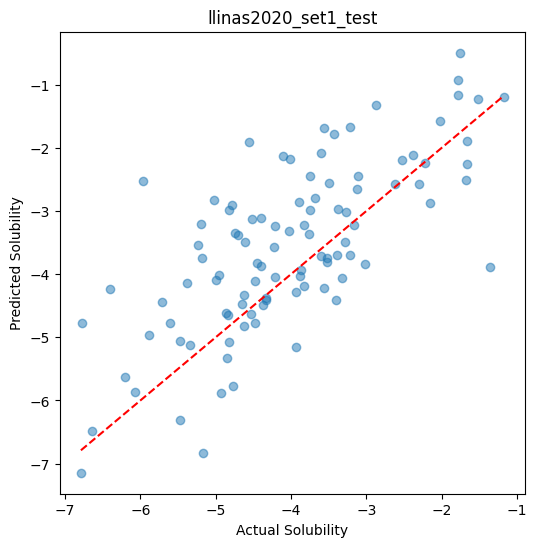

In [101]:
# llinas20202_set1_test RMSE and Pearson Correaltion

y_test_csv = pd.read_csv("Test_Datasets/llinas2020_set1_test.csv")
y_test = np.array(y_test_csv["y"])

smiles_list = np.array(y_test_csv["smiles"])
len = smiles_list.shape[0]
featurizer = dc.feat.Mol2VecFingerprint(pretrain_model_path=model_path)
features = [featurizer.featurize(smile) for smile in smiles_list]
features = np.array(features)
features= features.squeeze()  
features=features.reshape(len, 300)
features = scaler.transform(features)
predicted_y_test = model.predict(features).flatten() 
test_loss, test_mae = model.evaluate(features, y_test, verbose=0)
test_rmse = np.sqrt(test_loss)  
print(f"RMSE: {test_rmse:.3f}") 
corr_matrix_test = np.corrcoef(y_test, predicted_y_test)
corr_test = corr_matrix_test[0, 1]
print(f"Pearson Correlation: {corr_test:.3f}")
plot_correlation(y_test, predicted_y_test, "llinas2020_set1_test")

results_df = pd.DataFrame({
    "SMILES": smiles_list,
    "logS_actual": y_test,
    "logS_predicted": predicted_y_test
})

results_df.to_csv("Results/llinasSet1_predictions.csv", index=False)



[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
RMSE: 1.107
Pearson Correlation: 0.881


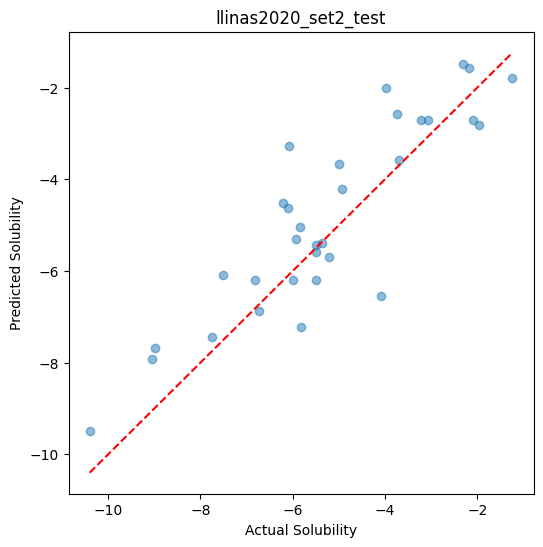

In [102]:
# llinas2020_set2_test RMSE and Pearson Correlation 

y_test_csv = pd.read_csv("Test_Datasets/llinas2020_set2_test.csv")
y_test = np.array(y_test_csv["y"])

smiles_list = np.array(y_test_csv["smiles"])
len = smiles_list.shape[0]
featurizer = dc.feat.Mol2VecFingerprint(pretrain_model_path=model_path)
features = [featurizer.featurize(smile) for smile in smiles_list]
features = np.array(features)
features= features.squeeze()  
features=features.reshape(len, 300)
features = scaler.transform(features)
predicted_y_test = model.predict(features).flatten() 
test_loss, test_mae = model.evaluate(features, y_test, verbose=0)
test_rmse = np.sqrt(test_loss)  
print(f"RMSE: {test_rmse:.3f}") 
corr_matrix_test = np.corrcoef(y_test, predicted_y_test)
corr_test = corr_matrix_test[0, 1]
print(f"Pearson Correlation: {corr_test:.3f}")

plot_correlation(y_test, predicted_y_test, "llinas2020_set2_test")


results_df = pd.DataFrame({
    "SMILES": smiles_list,
    "logS_actual": y_test,
    "logS_predicted": predicted_y_test
})

results_df.to_csv("Results/llinasSet2_predictions.csv", index=False)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

[22:10:29] DEPRECATION WARNING: please use MorganGenerator
[22:10:29] DEPRECATION WARNING: please use MorganGenerator
[22:10:29] DEPRECATION WARNING: please use MorganGenerator
[22:10:29] DEPRECATION WARNING: please use MorganGenerator
[22:10:29] DEPRECATION WARNING: please use MorganGenerator
[22:10:29] DEPRECATION WARNING: please use MorganGenerator
[22:10:29] DEPRECATION WARNING: please use MorganGenerator
[22:10:29] DEPRECATION WARNING: please use MorganGenerator
[22:10:29] DEPRECATION WARNING: please use MorganGenerator
[22:10:29] DEPRECATION WARNING: please use MorganGenerator
[22:10:29] DEPRECATION WARNING: please use MorganGenerator
[22:10:29] DEPRECATION WARNING: please use MorganGenerator
[22:10:29] DEPRECATION WARNING: please use MorganGenerator
[22:10:29] DEPRECATION WARNING: please use MorganGenerator
[22:10:29] DEPRECATION WARNING: please use MorganGenerator
[22:10:29] DEPRECATION WARNING: please use MorganGenerator
[22:10:29] DEPRECATION WARNING: please use MorganGenerat

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
RMSE: 0.805
Pearson Correlation: 0.899


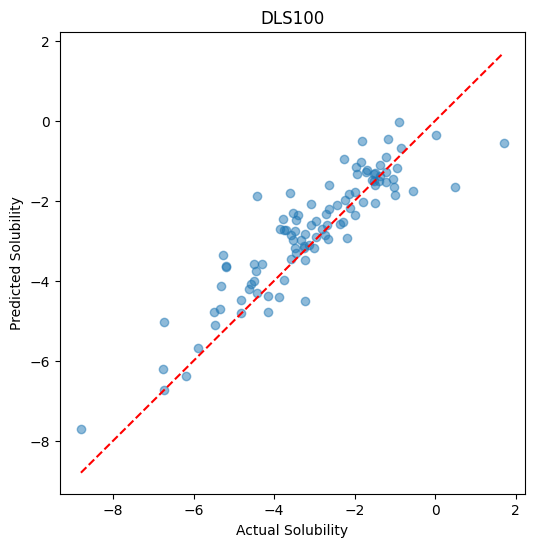

In [103]:
# DLS100 RMSE and Pearson Correlation

y_test_csv = pd.read_csv("Test_Datasets/DLS100.csv")
y_test = np.array(y_test_csv["logS"])

smiles_list = np.array(y_test_csv["SMILES"])
len = smiles_list.shape[0]
featurizer = dc.feat.Mol2VecFingerprint(pretrain_model_path=model_path)
features = [featurizer.featurize(smile) for smile in smiles_list]
features = np.array(features)
features= features.squeeze()  
features=features.reshape(len, 300)
features = scaler.transform(features)
predicted_y_test = model.predict(features).flatten() 
test_loss, test_mae = model.evaluate(features, y_test, verbose=0)
test_rmse = np.sqrt(test_loss)  
print(f"RMSE: {test_rmse:.3f}") 
corr_matrix_test = np.corrcoef(y_test, predicted_y_test)
corr_test = corr_matrix_test[0, 1]
print(f"Pearson Correlation: {corr_test:.3f}")

plot_correlation(y_test, predicted_y_test, "DLS100")

results_df = pd.DataFrame({
    "SMILES": smiles_list,
    "logS_actual": y_test,
    "logS_predicted": predicted_y_test
})

results_df.to_csv("Results/DLS100_predictions.csv", index=False)
